# Political parties

In [ ]:
import pandas as pd
from tqdm import tqdm
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch
from cleantext import clean

In [6]:
comments_df = pd.read_csv("data/youtube_comments_500.csv")
comments_df["Comments"] = comments_df["Comments"].astype(str)

def clean_text(text:str):
    text = clean(text, no_emoji=True, lang="de")
    new_text = []
    for token in text.split(" "):
        if not token.startswith('@') and not token.startswith('http'):
            new_text.append(token)
    return " ".join(new_text)

comments_df["Comments"] = comments_df["Comments"].apply(lambda text: clean_text(text))
comments_df =comments_df[comments_df.Comments != ""]
comments_df["Comments"]

0         wollt ihr jetzt jeden tag einen großen bericht...
1         wenn scholz alles besser weiss, wieso braucht ...
2         die grünen hatten früher das peace zeichen als...
3         der westen ist ein kriegstreiber bis es zu ein...
4                             frieden schaffen ohne waffen.
                                ...                        
406237    kann jeder deutscher werden ,kein problem sola...
406238    dann nimm die leute bei dir auf und verpflege ...
406239    als staatenloser hatt mans aber auch nicht lei...
406240    wann kommt der blackout? kinder könnt ihr ja e...
406241    den blackout auf den du wartest, wird es nur g...
Name: Comments, Length: 401282, dtype: object

In [ ]:
model_name = "UHH-CI/GermanPolitical-Gelectra-base"
sentiment_tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model_config = AutoConfig.from_pretrained(model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name, from_tf=True)

label_list = []
score_list = []

political_parties = ["cdu/csu","spd","fdp","grüne","die linke","afd"]

for text in tqdm(comments_df.Comments.to_list()):
    top_party_name = ""
    top_party_score = 0
    for party in political_parties:
        input_text = party+": "+text
        tokenized_input = sentiment_tokenizer(input_text, padding=True, truncation=True, return_tensors='pt', max_length=512)
        output = sentiment_model(**tokenized_input)
        prediction = torch.nn.functional.softmax(output.logits, dim=-1)
        prediction = prediction.detach().numpy()[0]
        if top_party_score < prediction[0]: # label[0] indicates the value for the consent
            top_party_name = party
            top_party_score = prediction[0]

    label_list.append(top_party_name)
    score_list.append(top_party_score)

comments_df["political_party"] = label_list
comments_df["political_party_score"] = score_list
comments_df.to_csv("data/political_parties.csv")

In [9]:
comments_df = pd.read_csv("data/political_parties.csv")
display(comments_df[["Comments", "political_party", "political_party_score"]])

,Comments,political_party,political_party_score
0,wollt ihr jetzt jeden tag einen großen bericht...,die linke,0.498146
1,"wenn scholz alles besser weiss, wieso braucht ...",spd,0.922301
2,die grünen hatten früher das peace zeichen als...,afd,0.629976
3,der westen ist ein kriegstreiber bis es zu ein...,cdu/csu,0.999133
4,frieden schaffen ohne waffen.,die linke,0.999104
...,...,...,...
401277,"kann jeder deutscher werden ,kein problem sola...",grüne,0.882378
401278,dann nimm die leute bei dir auf und verpflege ...,spd,0.999311
401279,als staatenloser hatt mans aber auch nicht lei...,die linke,0.997392
401280,wann kommt der blackout? kinder könnt ihr ja e...,afd,0.901219


(0.0, 0.5)

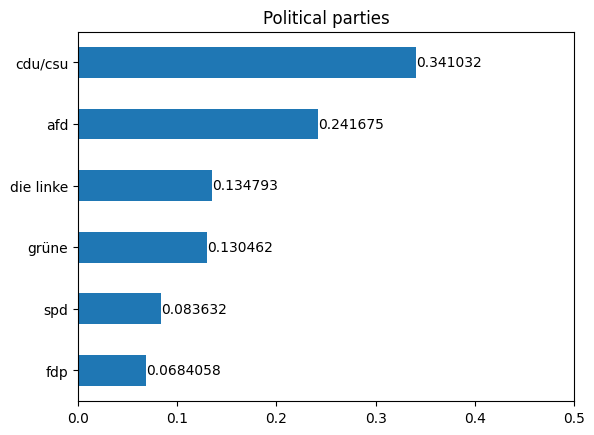

In [13]:
ax = comments_df["political_party"].value_counts(normalize=True).sort_values().plot(kind="barh", title="Political parties")
ax.bar_label(ax.containers[0])
ax.set_xlim(0,0.5)